
# Car Body Type Classification - Classical Machine Learning
# Dataset: Pre-split into train/val/test folders
# Features: HOG (shape) + HSV histogram (color)


## 1️⃣ Import Libraries

In [4]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## 2️⃣ Feature Extraction Function

In [5]:
def extract_features(image_path, resize=(128,128)):
    """
    Extracts HOG + HSV histogram features from an image.

    Args:
        image_path (str): path to the image
        resize (tuple): resize dimension for consistent HOG

    Returns:
        feature_vector (np.array): concatenated HOG + HSV features
    """
    # Read image
    img = cv2.imread(image_path)
    img = cv2.resize(img, resize)

    # ----- HOG Features (edges / shape) -----
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16,16),
        cells_per_block=(2,2),
        block_norm='L2-Hys',
        feature_vector=True
    )

    # ----- HSV Color Histogram (color information) -----
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, [16,16,8], [0,180,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()

    # ----- Combine HOG + HSV into a single feature vector -----
    feature_vector = np.hstack([hog_feat, hist])
    return feature_vector


## 3️⃣ Load Dataset from Folders

In [6]:
def load_dataset(folder_path):
    """
    Loads images and extracts features from a folder structure:
    folder_path/
        Class1/
            img1.jpg, img2.jpg...
        Class2/
            ...

    Args:
        folder_path (str): path to train/val/test folder

    Returns:
        X (np.array): feature vectors
        y (list): class labels (folder names)
    """
    X, y = [], []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            features = extract_features(img_path)
            X.append(features)
            y.append(class_name)
    return np.array(X), np.array(y)

# Paths to your dataset folders
train_dir = "dataset/train"
val_dir = "dataset/valid"
test_dir = "dataset/test"

# Load datasets
X_train, y_train = load_dataset(train_dir)
X_val, y_val = load_dataset(val_dir)
X_test, y_test = load_dataset(test_dir)

print("Dataset shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Dataset shapes:
X_train: (5350, 3812) y_train: (5350,)
X_val: (1397, 3812) y_val: (1397,)
X_test: (802, 3812) y_test: (802,)


## 4️⃣ Encode Labels

In [7]:
# Convert class names to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

## 5️⃣ Feature Selection

In [8]:
# 5a. Remove low-variance features (almost constant features)
var_thresh = VarianceThreshold(threshold=0.01)
X_train_sel = var_thresh.fit_transform(X_train)
X_val_sel = var_thresh.transform(X_val)
X_test_sel = var_thresh.transform(X_test)

# 5b. Select top K features using ANOVA F-test
k_best = SelectKBest(score_func=f_classif, k=2000)  # choose top 2000 features
X_train_sel = k_best.fit_transform(X_train_sel, y_train_enc)
X_val_sel = k_best.transform(X_val_sel)
X_test_sel = k_best.transform(X_test_sel)

print("Feature dimensions after selection:", X_train_sel.shape)


Feature dimensions after selection: (5350, 208)


C:\Users\20114\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=2000 is greater than n_features=208. All the features will be returned.
  warnings.warn(


## 6️⃣ Feature Scaling

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_val_scaled = scaler.transform(X_val_sel)
X_test_scaled = scaler.transform(X_test_sel)


## 7️⃣ Dimensionality Reduction with PCA

In [10]:
pca = PCA(n_components=0.95)  # keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Feature dimensions after PCA:", X_train_pca.shape)

Feature dimensions after PCA: (5350, 84)


## 8️⃣ Train Classical ML Models

In [11]:
models = {
    "SVM": SVC(kernel='rbf'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

best_model_name = ""
best_val_acc = 0
best_model = None

for name, model in models.items():
    # Train model on training set
    model.fit(X_train_pca, y_train_enc)
    # Validate on validation set
    y_val_pred = model.predict(X_val_pca)
    acc = accuracy_score(y_val_enc, y_val_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")

    # Keep track of the best model
    if acc > best_val_acc:
        best_val_acc = acc
        best_model = model
        best_model_name = name

print(f"\nBest model: {best_model_name} with validation accuracy {best_val_acc:.4f}")

SVM Validation Accuracy: 0.6722
RandomForest Validation Accuracy: 0.4989
KNN Validation Accuracy: 0.4953


C:\Users\20114\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:17:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Accuracy: 0.5297

Best model: SVM with validation accuracy 0.6722


## 9️⃣ Evaluate on Test Set


Test Accuracy: 0.6608478802992519

Classification Report:
              precision    recall  f1-score   support

 Convertible       0.76      0.72      0.74       174
       Coupe       0.41      0.44      0.43        79
   Hatchback       0.53      0.47      0.50        99
     Pick-Up       0.68      0.82      0.74       110
         SUV       0.64      0.64      0.64       125
       Sedan       0.58      0.57      0.58       109
         VAN       0.90      0.86      0.88       106

    accuracy                           0.66       802
   macro avg       0.64      0.65      0.64       802
weighted avg       0.66      0.66      0.66       802



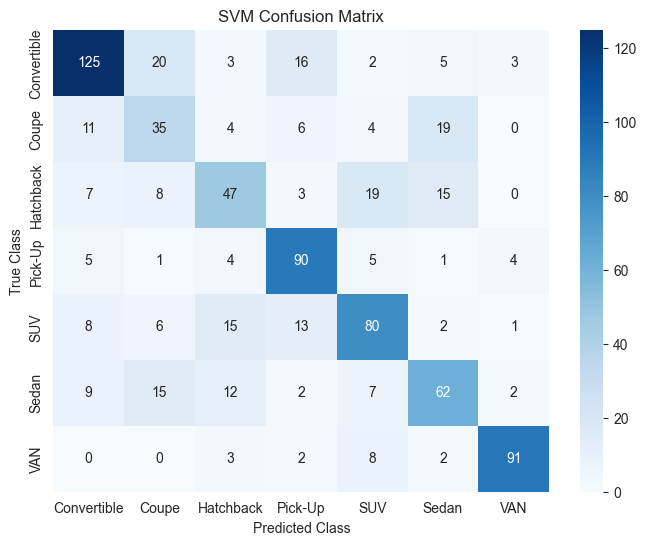

In [12]:
y_test_pred = best_model.predict(X_test_pca)
test_acc = accuracy_score(y_test_enc, y_test_pred)
print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title(f"{best_model_name} Confusion Matrix")
plt.show()